In [1]:
import geopandas as gpd
import matplotlib.colors as colors
import matplotlib.pyplot as plt
import modin.pandas as pd
import numpy as np
import shapely
from modin.config import ProgressBar
from tqdm.auto import tqdm

ProgressBar.enable()

In [2]:
wforms = (
    pd.read_parquet("wforms-bat.parquet")
    .join(pd.read_parquet("wforms-ann.parquet"), how="left")
    .join(pd.read_parquet("wforms-occ.parquet", columns=["rho", "tot", "fst", "lst", "top", "cvx"]).add_suffix("_occ"), how="left")
    .join(pd.read_parquet("wforms-usr.parquet", columns=["rho", "tot"]).add_suffix("_usr"), how="left")
)

# Previously attested forms and hashtags get a special status value.
wforms["is_hashtag"] = wforms.index.str.startswith("#")
wforms.loc[wforms["is_hashtag"], "status"] = -np.inf
wforms.loc[wforms["tt_att"], "status"] = +np.inf

# Quick stats check.
wforms[wforms["fst_batch"] | wforms["snd_batch"]]["status"].value_counts(dropna=False)

To remove this warning, run the following python code before doing dataframe operations:

    import ray
    ray.init()

2023-09-06 09:01:25,634	INFO worker.py:1621 -- Started a local Ray instance.


Estimated completion of line 2:   0%           Elapsed time: 00:00, estimated remaining time: ?

Estimated completion of line 3:   0%           Elapsed time: 00:00, estimated remaining time: ?

Estimated completion of line 4:   0%           Elapsed time: 00:00, estimated remaining time: ?

Estimated completion of line 5:   0%           Elapsed time: 00:00, estimated remaining time: ?

Estimated completion of line 9:   0%           Elapsed time: 00:00, estimated remaining time: ?

Estimated completion of line 10:   0%           Elapsed time: 00:00, estimated remaining time: ?

Estimated completion of line 11:   0%           Elapsed time: 00:00, estimated remaining time: ?

Estimated completion of line 14:   0%           Elapsed time: 00:00, estimated remaining time: ?

status
 inf    15366
-1.0     7711
-inf     3391
 1.0      346
 NaN       76
Name: count, dtype: int64

# Restricting $\rho_O$

Estimated completion of line 1:   0%           Elapsed time: 00:00, estimated remaining time: ?

Estimated completion of line 5:   0%           Elapsed time: 00:00, estimated remaining time: ?

Estimated completion of line 8:   0%           Elapsed time: 00:00, estimated remaining time: ?

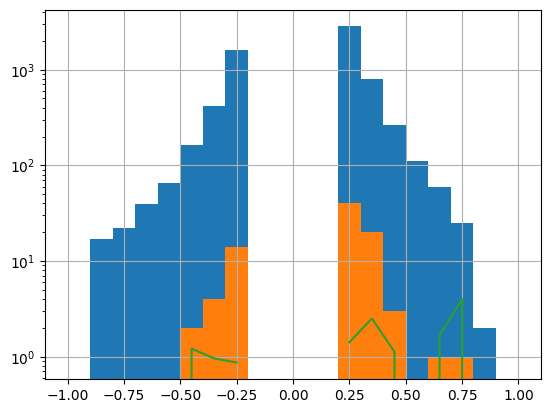

In [101]:
subset = wforms[abs(wforms["rho_occ"])>0.2]

bins = np.linspace(-1,1,20+1)
subset['rho_occ'].hist(bins=bins)
subset[subset['status'] == 1]['rho_occ'].hist(bins=bins, log=True)
#plt.axvspan(-0.2, 0.2, facecolor='w', hatch='/', alpha=0.2)

histt, bin_edges = np.histogram(subset[subset["status"].eq(1)]["rho_occ"], bins=bins)
histn, bin_edges = np.histogram(subset["rho_occ"], bins=bins)
plt.plot(bin_edges[:-1]+0.05, histt/histn*100)

plt.show()

Estimated completion of line 1:   0%           Elapsed time: 00:00, estimated remaining time: ?

Estimated completion of line 5:   0%           Elapsed time: 00:00, estimated remaining time: ?

Estimated completion of line 8:   0%           Elapsed time: 00:00, estimated remaining time: ?

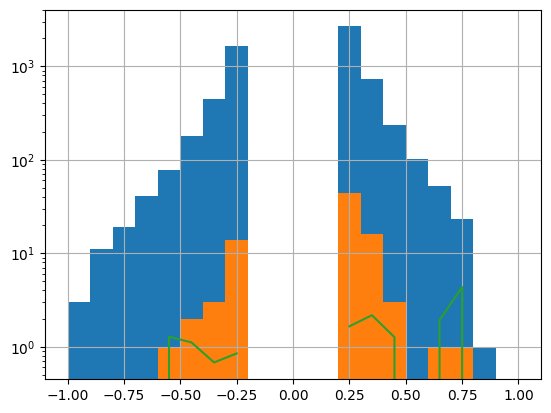

In [102]:
subset = wforms[abs(wforms["rho_usr"])>0.2]

bins = np.linspace(-1,1,20+1)
subset['rho_usr'].hist(bins=bins)
subset[subset['status'] == 1]['rho_usr'].hist(bins=bins, log=True)
#plt.axvspan(-0.2, 0.2, facecolor='w', hatch='/', alpha=0.2)

histt, bin_edges = np.histogram(subset[subset["status"].eq(1)]["rho_usr"], bins=bins)
histn, bin_edges = np.histogram(subset["rho_usr"], bins=bins)
plt.plot(bin_edges[:-1]+0.05, histt/histn*100)

plt.show()

Estimated completion of line 6:   0%           Elapsed time: 00:00, estimated remaining time: ?

Estimated completion of line 7:   0%           Elapsed time: 00:00, estimated remaining time: ?

Estimated completion of line 10:   0%           Elapsed time: 00:00, estimated remaining time: ?

Estimated completion of line 12:   0%           Elapsed time: 00:00, estimated remaining time: ?

Estimated completion of line 14:   0%           Elapsed time: 00:00, estimated remaining time: ?

Estimated completion of line 15:   0%           Elapsed time: 00:00, estimated remaining time: ?

Estimated completion of line 16:   0%           Elapsed time: 00:00, estimated remaining time: ?

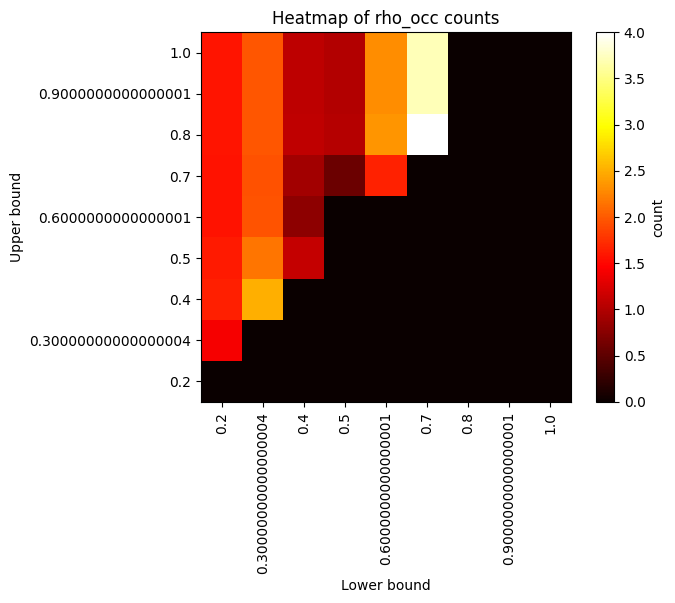

In [85]:
lower_bounds = np.linspace(0.2, 1, 9)
upper_bounds = np.linspace(0.2, 1, 9)[::-1]

counts = np.zeros((len(upper_bounds), len(lower_bounds)))

subset = wforms[wforms["rho_occ"] > 0.2]
ok = subset["status"].eq(1)

for i, lower in enumerate(lower_bounds):
    lo = subset['rho_occ'] > lower
    for j, upper in enumerate(upper_bounds):
        hi = subset['rho_occ'] <= upper
        if lower < upper:
            foo = lo & hi
            tot = foo.sum()
            counts[j, i] = 0 if tot == 0 else (foo & ok).sum() / tot * 100

plt.imshow(counts, cmap='hot')
plt.colorbar(label='count')
plt.xticks(np.arange(len(lower_bounds)), lower_bounds, rotation=90)
plt.yticks(np.arange(len(upper_bounds)), upper_bounds)
plt.xlabel('Lower bound')
plt.ylabel('Upper bound')
plt.title('Heatmap of rho_occ counts')

plt.show()

Estimated completion of line 1:   0%           Elapsed time: 00:00, estimated remaining time: ?

Estimated completion of line 2:   0%           Elapsed time: 00:00, estimated remaining time: ?

array([13594,  4191,  1643,   738,   368,   202,   115,    61,    44,
          34,    28,    36,    38,    29])

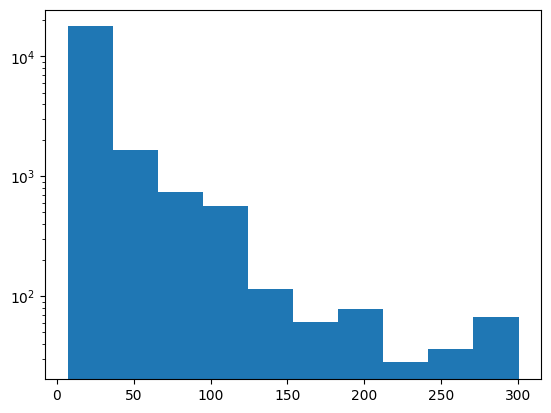

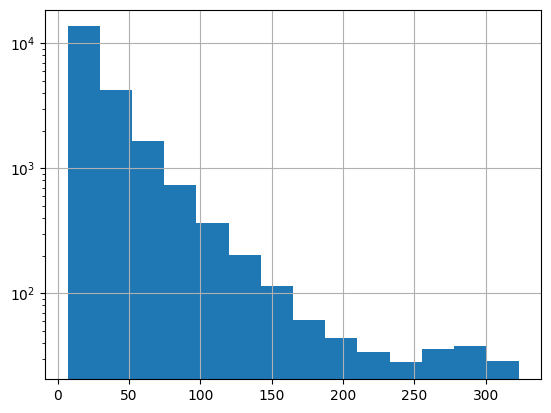

In [127]:
subset = wforms[wforms["snd_batch"]]
df_status_1 = subset[subset['status'] == 1]



chs, ces = np.histogram(df_status_1['fst_occ'], bins=np.linspace(7, 323, 15))
nhs, nes = np.histogram(subset['fst_occ'], bins=np.linspace(7, 323, 15))

plt.hist(nes[:-1], weights=nhs, log=True)
display(nhs)
plt.show()

subset['fst_occ'].hist(bins=np.linspace(7, 323, 15), log=True)
plt.show()
#df_status_1['fst_occ'].hist(bins=np.linspace(7, 323, 15), log=True)
# Ok, this is getting somewhere

Estimated completion of line 1:   0%           Elapsed time: 00:00, estimated remaining time: ?

Estimated completion of line 2:   0%           Elapsed time: 00:00, estimated remaining time: ?

<Axes: >

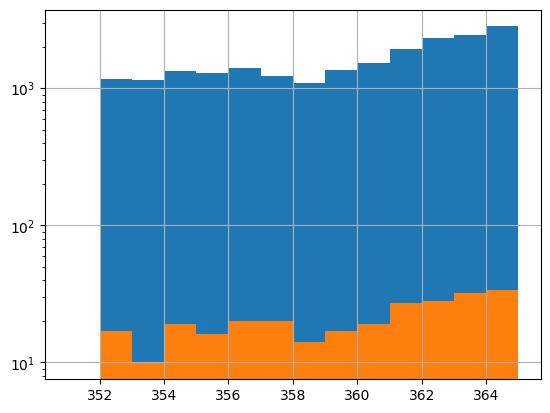

In [79]:
subset = wforms[wforms["snd_batch"]]
df_status_1 = subset[subset['status'] == 1]

subset['lst_occ'].hist(bins=np.linspace(365-14,365,15))
df_status_1['lst_occ'].hist(bins=np.linspace(365-14,365,15), log=True)
# Ok, this is getting somewhere

In [83]:
((wforms["rho_occ"] > 0.9) & (wforms["rho_occ"] <= 1.0)).sum()

Estimated completion of line 1:   0%           Elapsed time: 00:00, estimated remaining time: ?

0

Estimated completion of line 6:   0%           Elapsed time: 00:00, estimated remaining time: ?

Estimated completion of line 7:   0%           Elapsed time: 00:00, estimated remaining time: ?

Estimated completion of line 10:   0%           Elapsed time: 00:00, estimated remaining time: ?

Estimated completion of line 12:   0%           Elapsed time: 00:00, estimated remaining time: ?

Estimated completion of line 14:   0%           Elapsed time: 00:00, estimated remaining time: ?

Estimated completion of line 15:   0%           Elapsed time: 00:00, estimated remaining time: ?

Estimated completion of line 16:   0%           Elapsed time: 00:00, estimated remaining time: ?

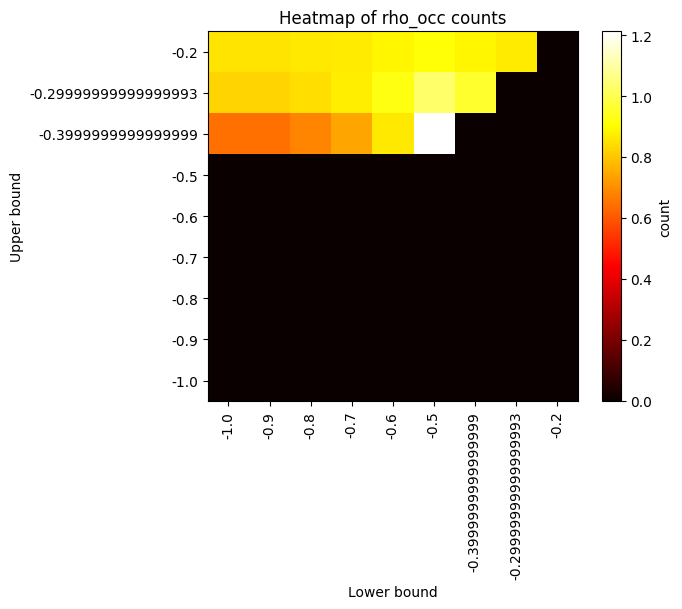

In [87]:
lower_bounds = np.linspace(-1, -0.2, 9)
upper_bounds = np.linspace(-1, -0.2, 9)[::-1]

counts = np.zeros((len(upper_bounds), len(lower_bounds)))

subset = wforms[wforms["rho_occ"] < 0.2]
ok = subset["status"].eq(1)

for i, lower in enumerate(lower_bounds):
    lo = subset['rho_occ'] > lower
    for j, upper in enumerate(upper_bounds):
        hi = subset['rho_occ'] <= upper
        if lower < upper:
            foo = lo & hi
            tot = foo.sum()
            counts[j, i] = 0 if tot == 0 else (foo & ok).sum() / tot * 100

plt.imshow(counts, cmap='hot')
plt.colorbar(label='count')
plt.xticks(np.arange(len(lower_bounds)), lower_bounds, rotation=90)
plt.yticks(np.arange(len(upper_bounds)), upper_bounds)
plt.xlabel('Lower bound')
plt.ylabel('Upper bound')
plt.title('Heatmap of rho_occ counts')

plt.show()

Estimated completion of line 6:   0%           Elapsed time: 00:00, estimated remaining time: ?

Estimated completion of line 7:   0%           Elapsed time: 00:00, estimated remaining time: ?

Estimated completion of line 10:   0%           Elapsed time: 00:00, estimated remaining time: ?

Estimated completion of line 12:   0%           Elapsed time: 00:00, estimated remaining time: ?

Estimated completion of line 14:   0%           Elapsed time: 00:00, estimated remaining time: ?

Estimated completion of line 15:   0%           Elapsed time: 00:00, estimated remaining time: ?

Estimated completion of line 16:   0%           Elapsed time: 00:00, estimated remaining time: ?

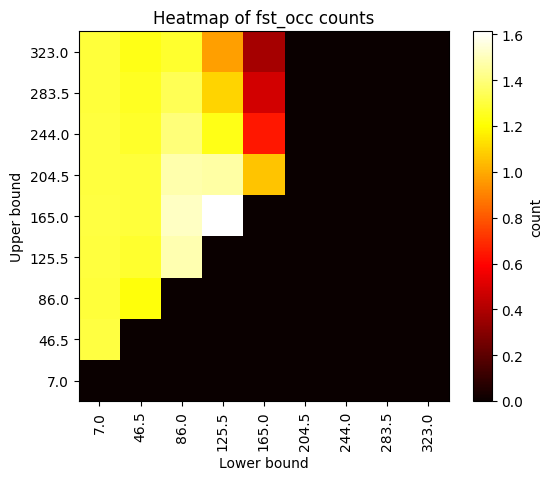

In [28]:
lower_bounds = np.linspace(7, 323, 9)
upper_bounds = np.linspace(7, 323, 9)[::-1]

counts = np.zeros((len(upper_bounds), len(lower_bounds)))

subset = wforms[wforms["snd_batch"]]
ok = subset["status"].eq(1)

for i, lower in enumerate(lower_bounds):
    lo = subset['fst_occ'] > lower
    for j, upper in enumerate(upper_bounds):
        hi = subset['fst_occ'] <= upper
        if lower < upper:
            foo = lo & hi
            tot = foo.sum()
            counts[j, i] = 0 if tot == 0 else (foo & ok).sum() / tot * 100

plt.imshow(counts, cmap='hot')
plt.colorbar(label='count')
plt.xticks(np.arange(len(lower_bounds)), lower_bounds, rotation=90)
plt.yticks(np.arange(len(upper_bounds)), upper_bounds)
plt.xlabel('Lower bound')
plt.ylabel('Upper bound')
plt.title('Heatmap of fst_occ counts')

plt.show()

Estimated completion of line 6:   0%           Elapsed time: 00:00, estimated remaining time: ?

Estimated completion of line 7:   0%           Elapsed time: 00:00, estimated remaining time: ?

Estimated completion of line 10:   0%           Elapsed time: 00:00, estimated remaining time: ?

Estimated completion of line 12:   0%           Elapsed time: 00:00, estimated remaining time: ?

Estimated completion of line 14:   0%           Elapsed time: 00:00, estimated remaining time: ?

Estimated completion of line 15:   0%           Elapsed time: 00:00, estimated remaining time: ?

Estimated completion of line 16:   0%           Elapsed time: 00:00, estimated remaining time: ?

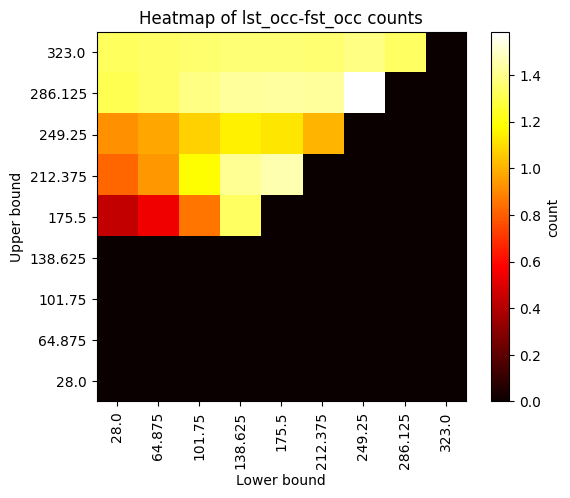

In [8]:
lower_bounds = np.linspace(28, 323, 9)
upper_bounds = np.linspace(28, 323, 9)[::-1]

counts = np.zeros((len(upper_bounds), len(lower_bounds)))

subset = wforms[wforms["snd_batch"]]
ok = subset["status"].eq(1)

for i, lower in enumerate(lower_bounds):
    lo = (subset['lst_occ'] - subset['fst_occ']) > lower
    for j, upper in enumerate(upper_bounds):
        hi = (subset['lst_occ'] - subset['fst_occ']) <= upper
        if lower < upper:
            foo = lo & hi
            tot = foo.sum()
            counts[j, i] = 0 if tot == 0 else (foo & ok).sum() / tot * 100

plt.imshow(counts, cmap='hot')
plt.colorbar(label='count')
plt.xticks(np.arange(len(lower_bounds)), lower_bounds, rotation=90)
plt.yticks(np.arange(len(upper_bounds)), upper_bounds)
plt.xlabel('Lower bound')
plt.ylabel('Upper bound')
plt.title('Heatmap of lst_occ-fst_occ counts')

plt.show()

ok, all these are fkn unreadable for a normal person

Estimated completion of line 8:   0%           Elapsed time: 00:00, estimated remaining time: ?

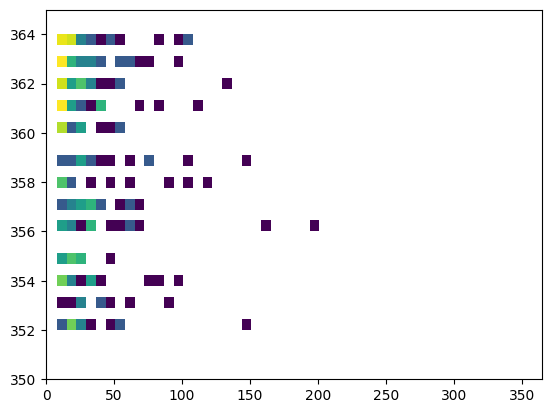

In [106]:
import matplotlib.colors as colors
import matplotlib.gridspec as gridspec
import matplotlib.patches as mpatches
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter


df = wforms[wforms["status"].eq(1) & wforms["snd_batch"]]

counts, xedges, yedges = np.histogram2d(df["fst_occ"], df["lst_occ"], bins=55 // 2)

plt.xlim((0,365))
plt.ylim((350,365))
plt.pcolormesh(xedges, yedges, counts.T, norm=colors.LogNorm())#, **style_hist)

Estimated completion of line 1:   0%           Elapsed time: 00:00, estimated remaining time: ?

Estimated completion of line 5:   0%           Elapsed time: 00:00, estimated remaining time: ?

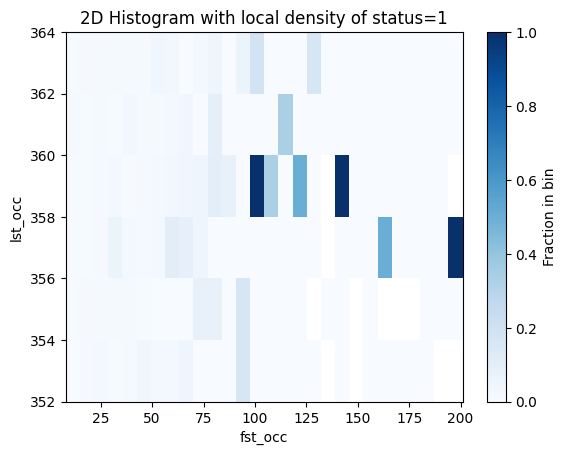

In [27]:

subset = wforms[wforms["snd_batch"]]

# Assuming wforms is your DataFrame
# Filter rows where status is 1
df_status_1 = subset[subset['status'] == 1]

# Create 2D histogram data
nhist, xedges, yedges = np.histogram2d(subset['fst_occ'], subset['lst_occ'], bins=(28,6))
chist, xedges, yedges = np.histogram2d(df_status_1['fst_occ'], df_status_1['lst_occ'], bins=(28,6))

# Create a meshgrid for the bin edges
X, Y = np.meshgrid(xedges, yedges)

# Plot the 2D histogram using pcolormesh
plt.pcolormesh(X, Y, (chist/nhist).T, cmap='Blues')
cb = plt.colorbar()
cb.set_label('Fraction in bin')

plt.title('2D Histogram with local density of status=1')
plt.xlabel('fst_occ')
plt.ylabel('lst_occ')
plt.show()

Estimated completion of line 1:   0%           Elapsed time: 00:00, estimated remaining time: ?

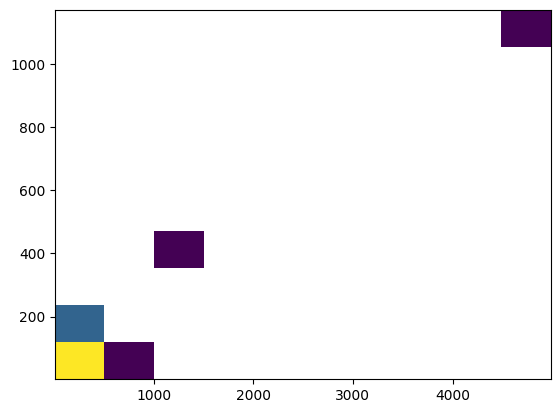

In [16]:

df = wforms[wforms["status"].eq(1) & wforms["fst_batch"]]

counts, xedges, yedges = np.histogram2d(df["tot_occ"], df["tot_usr"])#, bins=55 // 2)

plt.pcolormesh(xedges, yedges, counts.T, norm=colors.LogNorm())#, **style_hist)

# Old stuff

In [ ]:
rho_thresholdsp = pd.Series(np.linspace(0.2, 1, 50))
rho_thresholdsn = pd.Series(np.linspace(-1, -0.2, 50))

testp = wforms[(~wforms["tt_att"]) & wforms["fst_batch"] & (wforms["rho"] > 0.2)]
testn = wforms[(~wforms["tt_att"]) & wforms["fst_batch"] & (wforms["rho"] < -0.2)]


fig, ax1 = plt.subplots()
ax2 = ax1.twinx()

ax1.plot(
    rho_thresholdsp,
    rho_thresholdsp.apply(lambda t: (testp["rho"] >= t).sum()),
    color="red"
)

ax2.plot(
    rho_thresholdsp,
    rho_thresholdsp.apply(lambda t: ((testp["rho"] >= t) & testp["status"].ge(0)).mean())/rho_thresholdsp.apply(lambda t: (testp["rho"] >= t).sum()),
)


ax1.plot(
    rho_thresholdsn,
    rho_thresholdsn.apply(lambda t: (testn["rho"] <= t).sum()),
    color="red"
)

ax2.plot(
    rho_thresholdsn,
    rho_thresholdsn.apply(lambda t: ((testn["rho"] <= t) & testn["status"].ge(0)).mean())/rho_thresholdsn.apply(lambda t: (testn["rho"] <= t).sum()),
)


fig.tight_layout()
plt.show()

In [ ]:
fst_thresholds = pd.Series(np.arange(7,366,5))
lst_thresholds = pd.Series(np.arange(351,366))

testf = wforms[wforms["snd_batch"] & (wforms["fst"] > 7)]
testl = wforms[wforms["snd_batch"] & (wforms["lst"] > 351)]


fig, ax1 = plt.subplots()
ax2 = ax1.twinx()

ax1.plot(
    fst_thresholds,
    fst_thresholds.apply(lambda t: (testf["fst"] >= t).sum()),
    color="red"
)

ax2.plot(
    fst_thresholds,
    fst_thresholds.apply(lambda t: ((testf["fst"] >= t) & testf["status"].eq(1)).mean()),#/fst_thresholds.apply(lambda t: (testf["fst"] >= t).sum()),
)


ax1.plot(
    lst_thresholds,
    lst_thresholds.apply(lambda t: (testl["lst"] >= t).sum()),
    color="red"
)

ax2.plot(
    lst_thresholds,
    lst_thresholds.apply(lambda t: ((testl["lst"] >= t) & testl["status"].eq(1)).mean()),#/lst_thresholds.apply(lambda t: (testl["lst"] >= t).sum()),
)


fig.tight_layout()
plt.show()

## convexity

In [ ]:
thresholds = pd.Series(np.linspace(-1,+1,20))

test = wforms[wforms["snd_batch"] & ~wforms["cvx"].isna()]

fig, ax1 = plt.subplots()
ax2 = ax1.twinx()

ax1.plot(
    thresholds,
    thresholds.apply(lambda t: (test["cvx"] <= t).sum()),
    color="red",
)

ax2.plot(
    thresholds,
    thresholds.apply(lambda t: ((test["cvx"] <= t) & test["status"].eq(1)).mean()),
    color="blue",
    label="yield",
)

plt.legend()

fig.tight_layout()
plt.show()

In [ ]:
thresholds = pd.Series(np.linspace(-1,+1,20))

test = wforms[wforms["snd_batch"] & ~wforms["cvx"].isna()]

fig, ax1 = plt.subplots()
ax2 = ax1.twinx()

ax1.plot(
    thresholds,
    thresholds.apply(lambda t: (test["cvx"] >= t).sum()),
    color="red",
)

ax2.plot(
    thresholds,
    thresholds.apply(lambda t: ((test["cvx"] >= t) & test["status"].eq(1)).mean()),
    color="blue",
    label="yield",
)

plt.legend()

fig.tight_layout()
plt.show()

In [ ]:
thresholds = pd.Series(np.linspace(0,+1,100))

test = wforms[wforms["snd_batch"] & ~wforms["cvx"].isna()]

fig, ax1 = plt.subplots()
ax2 = ax1.twinx()

ax1.plot(
    thresholds,
    thresholds.apply(lambda t: ((test["cvx"]) >= t).sum()),
    color="red",
)

ax2.plot(
    thresholds,
    thresholds.apply(lambda t: (((test["cvx"]) >= t) & test["status"].eq(1)).mean()),#/thresholds.apply(lambda t: ((test["cvx"]) >= t).sum()),
    color="blue",
    label="yield",
)

plt.legend()

fig.tight_layout()
plt.show()

In [ ]:
thresholds = pd.Series(np.linspace(-1,0,100))

test = wforms[wforms["snd_batch"] & ~wforms["cvx"].isna()]

fig, ax1 = plt.subplots()
ax2 = ax1.twinx()

ax1.plot(
    thresholds,
    thresholds.apply(lambda t: ((test["cvx"]) <= t).sum()),
    color="red",
)

ax2.plot(
    thresholds,
    thresholds.apply(lambda t: (((test["cvx"]) <= t) & test["status"].eq(1)).mean()),#/thresholds.apply(lambda t: ((test["cvx"]) <= t).sum()),
    color="blue",
    label="yield",
)

plt.legend()

fig.tight_layout()
plt.show()

In [ ]:
thresholds = pd.Series(np.linspace(0,+1,100))

test = wforms[wforms["snd_batch"] & ~wforms["cvx"].isna()]

fig, ax1 = plt.subplots()
ax2 = ax1.twinx()

ax1.plot(
    thresholds,
    thresholds.apply(lambda t: (abs(test["cvx"]) >= t).sum()),
    color="red",
)

ax2.plot(
    thresholds,
    thresholds.apply(lambda t: ((abs(test["cvx"]) >= t) & test["status"].ge(0)).mean())/thresholds.apply(lambda t: (abs(test["cvx"]) >= t).sum()),
    color="blue",
    label="yield",
)

plt.legend()

fig.tight_layout()
plt.show()